In [26]:
from langchain_community.chat_models import ChatOllama
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate
from langserve import RemoteRunnable
from langchain_core.runnables import RunnableParallel
import bs4
from langchain_community.document_loaders import TextLoader
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain import hub
from langchain_core.runnables import RunnablePassthrough
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field

In [27]:
# pdf_path = "../assets/240626_수요액티브전술집_LBM.pdf"
pdf_path = "../assets/230517 (보도자료) AI 대응전략 세미나 개최.pdf"

# 이미지 RAG

In [28]:
import fitz  # PyMuPDF
import io
from PIL import Image
import base64
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage
import os

def extract_images_from_pdf(pdf_path):
    """PDF 이미지 추출"""
    doc = fitz.open(pdf_path)
    images = []
    for page in doc:
        image_list = page.get_images()
        for img in image_list:
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            image = Image.open(io.BytesIO(image_bytes))
            images.append(image)
    return images

images = extract_images_from_pdf(pdf_path)
images

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1450x448>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=2525x1026>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2525x1026>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=94x33>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x63>]

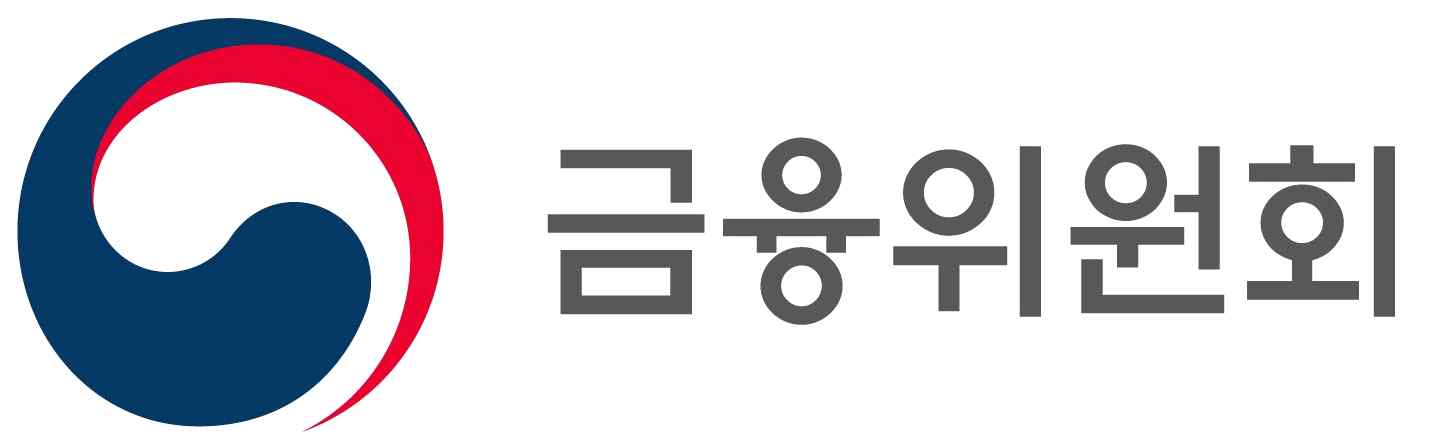

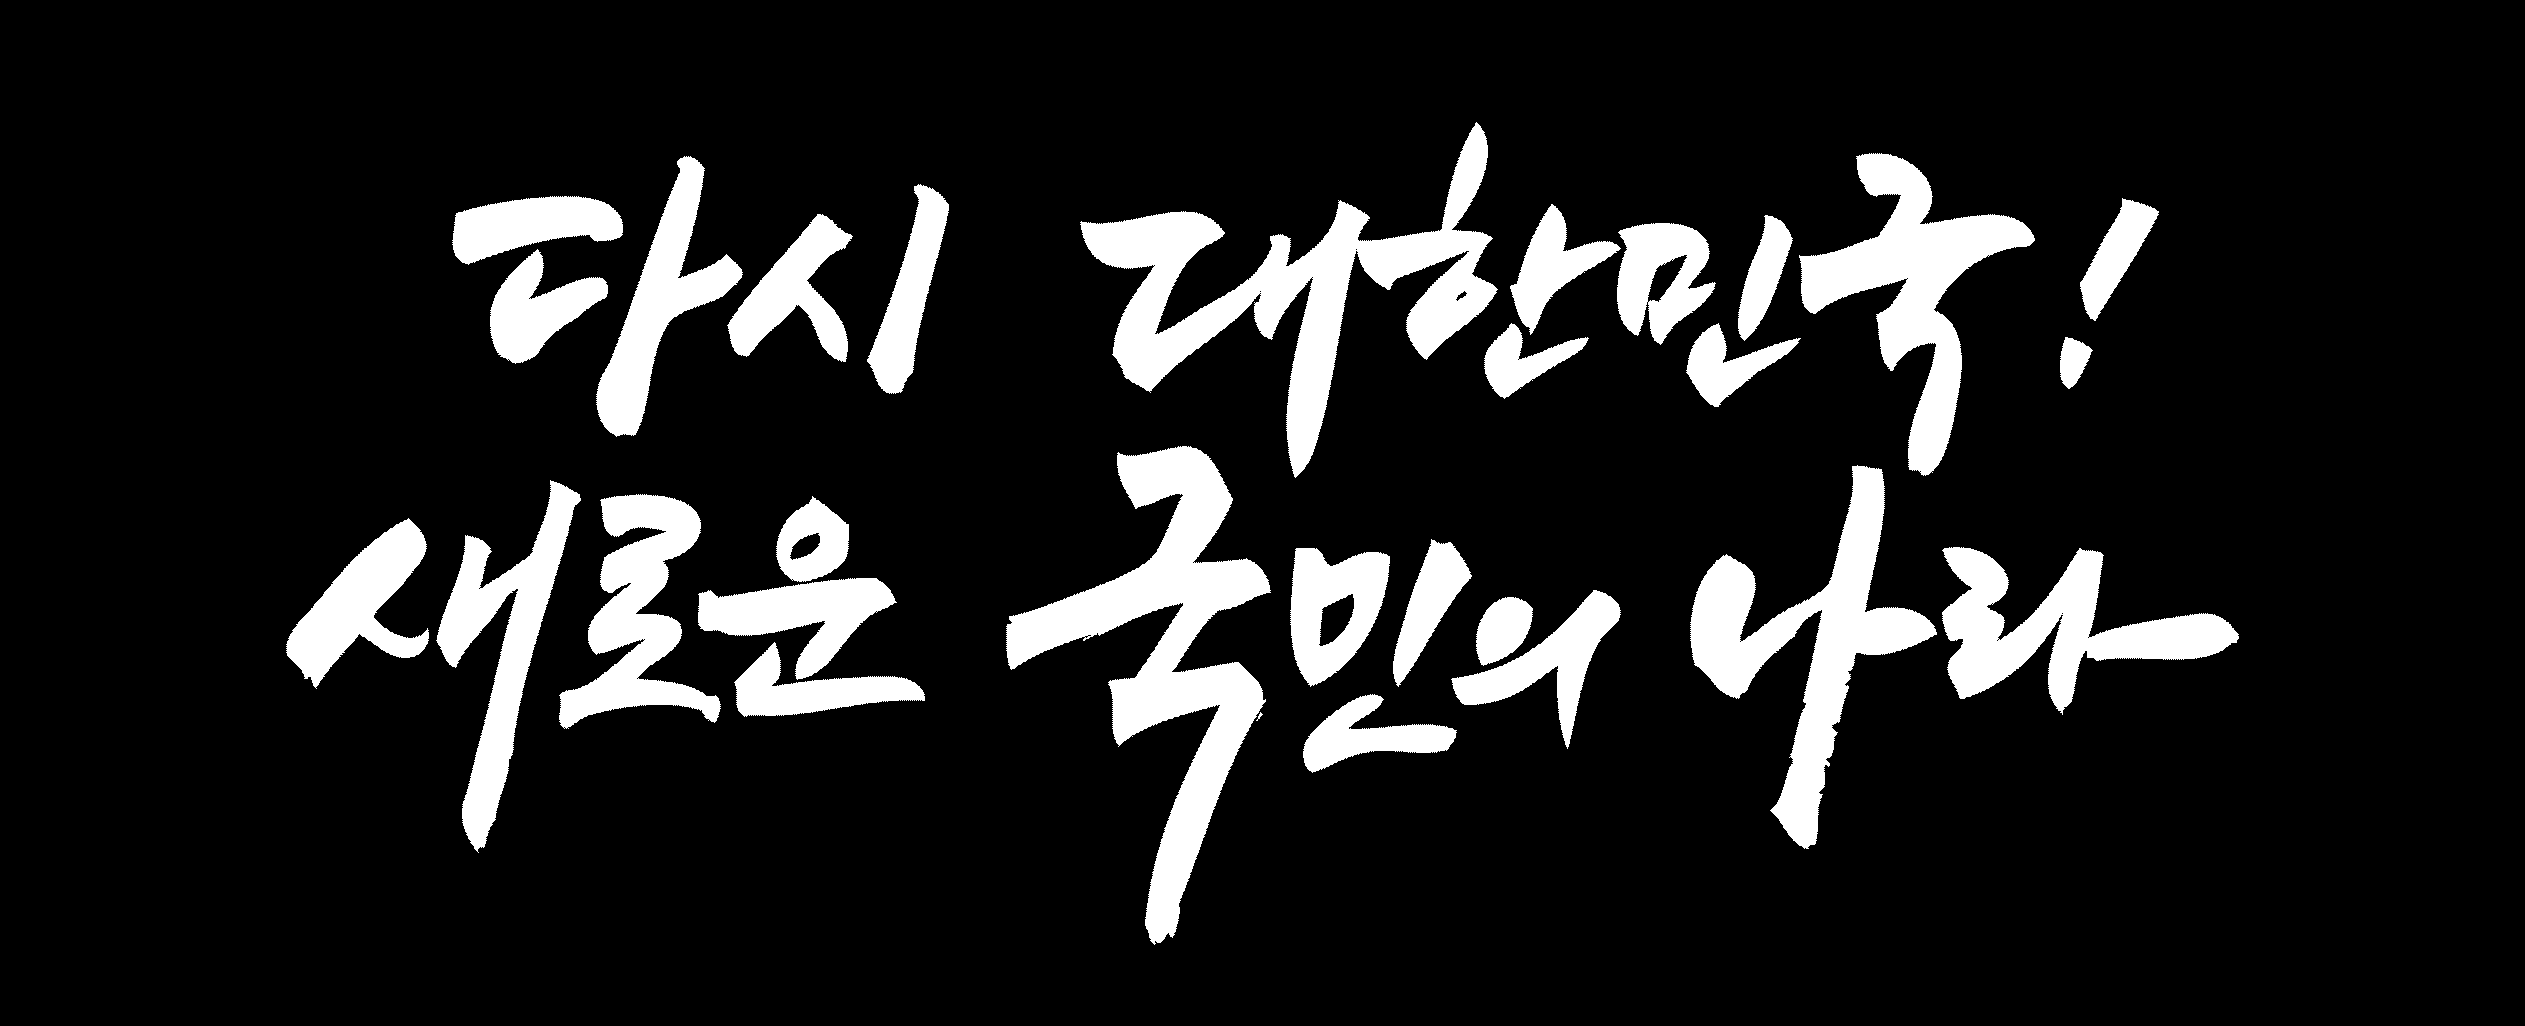

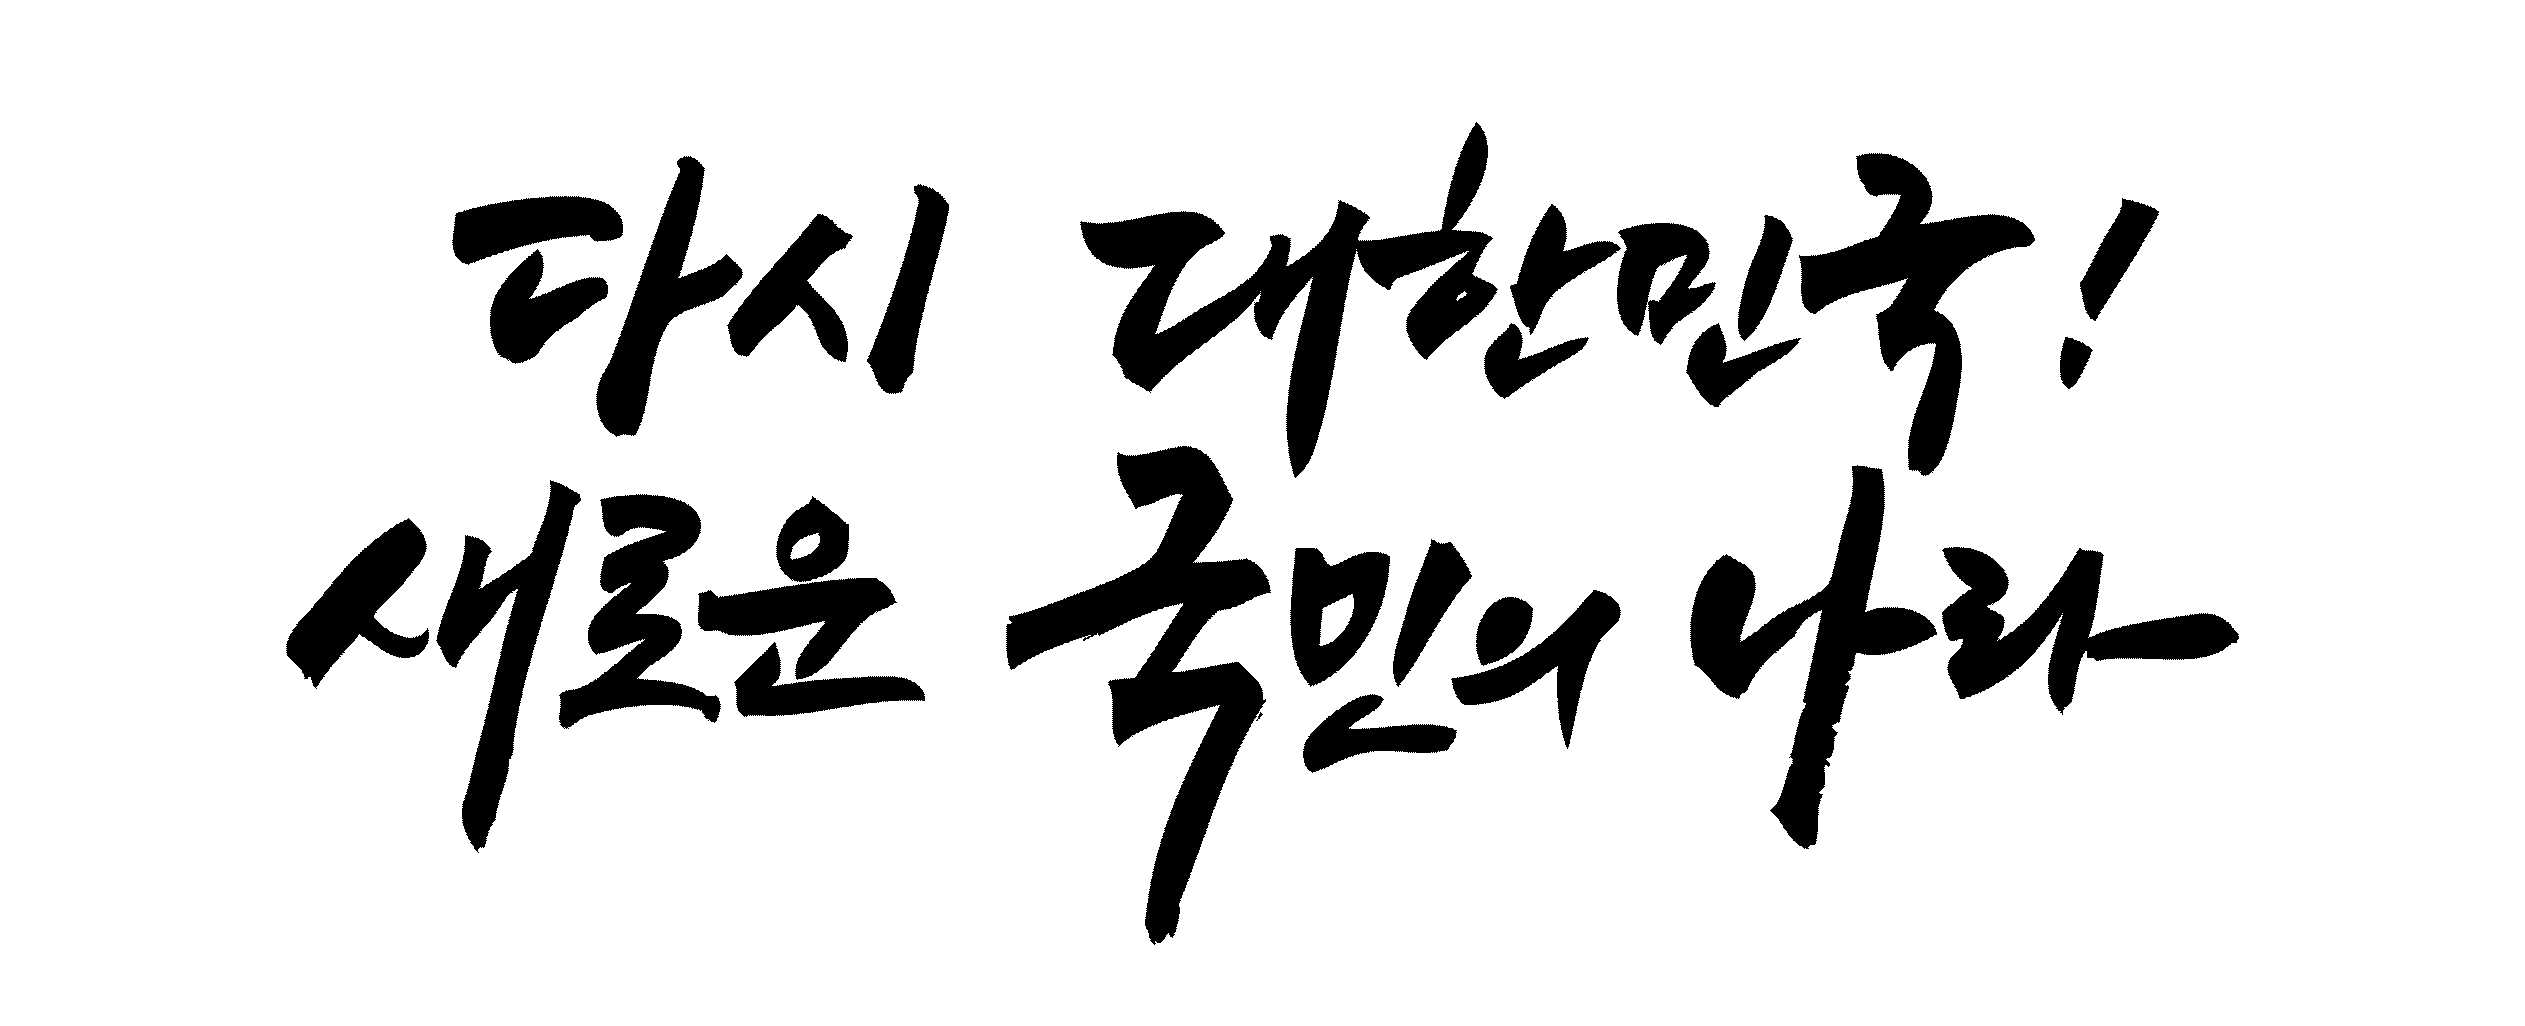

In [29]:
from IPython.display import display
for img in images[:3]:
    display(img)

In [31]:
# def image_to_base64(image):
#     """이미지를 base64 인코딩된 문자열로 변환합니다."""
#     buffered = io.BytesIO()
#     image.save(buffered, format="PNG")
#     return base64.b64encode(buffered.getvalue()).decode()

# def summarize_image(image, llm):
#     """이미지를 요약합니다."""
#     base64_image = image_to_base64(image)
    
#     system_message = SystemMessage(content="너는 이미지를 분석하고 설명하는 AI 어시스턴트야. 주어진 이미지를 간단히 설명해줘.")
#     human_message = HumanMessage(content=f"이 이미지를 간단히 설명해주세요: data:image/png;base64,{base64_image}")
    
#     messages = [system_message, human_message]
    
#     response = llm.invoke(messages)
#     return response.content

# def extract_and_summarize(pdf_path):
#     """PDF에서 이미지를 추출하고 각 이미지를 요약합니다."""
#     llm = ChatOllama(model="qwen2:latest")
    
#     images = extract_images_from_pdf(pdf_path)
#     for i, image in enumerate(images[:3]):
#         summary = summarize_image(image, llm)
#         print(f"이미지 {i+1} 요약:")
#         print(summary)
#         print("-" * 50)

# extract_and_summarize(pdf_path)

# 표 RAG

In [30]:
import camelot

# PDF 파일에서 표 추출
tables = camelot.read_pdf(pdf_path, pages='all')

# 추출된 표의 수 출력
print(f"총 {len(tables)}개 표 추출")
print("==================================")

# 첫 번째 표 데이터 확인
print(tables[0].df)

# 모든 표를 CSV 파일로 저장
# for i, table in enumerate(tables):
#     table.to_csv(f'table_{i+1}.csv')

# 표 정확도 확인
print(tables[0].parsing_report)

총 1개 표 추출
       0                1    2                          3
0  담당 부서  금융위원회\n금융데이터정책과  책임자  과  장 \n신장수 (02-2100-2620)
1                          담당자    사무관\n조윤수 (02-2100-2625)
2         한국신용정보원\n빅데이터센터  책임자    센터장\n이철흠 (02-3705-5433)
3                          담당자   팀  장\n최재철 (02-3705-5767)
{'accuracy': 100.0, 'whitespace': 31.25, 'order': 1, 'page': 7}


In [32]:
tables[0].df

,0,1,2,3
0,담당 부서,금융위원회\n금융데이터정책과,책임자,과 장 \n신장수 (02-2100-2620)
1,,,담당자,사무관\n조윤수 (02-2100-2625)
2,,한국신용정보원\n빅데이터센터,책임자,센터장\n이철흠 (02-3705-5433)
3,,,담당자,팀 장\n최재철 (02-3705-5767)


In [49]:
table_summary_prompt = ChatPromptTemplate.from_messages([
    ("system", """
당신은 주어진 CSV 데이터를 분석하고 그 내용을 자연어로 명확하게 요약하는 전문가입니다. 다음 데이터를 바탕으로 요약을 작성해 주세요:

{csv_data}

요약 작성 시 다음 지침을 따라주세요:
- 데이터의 출처나 형식(예: CSV 파일)에 대한 언급은 하지말 것
- 표의 행과 열에 대한 언급은 하지말 것
- 자연스럽고 읽기 쉬운 문체로 답변할 것

이 요약은 데이터에 대한 통찰력 있는 개요를 제공해야 하며, 독자가 주요 정보를 쉽게 이해할 수 있도록 해야 합니다.

"""
    ),
])

llm = ChatOllama(model="qwen2:latest", temperature=0) 
table_summary_chain = ({"csv_data": RunnablePassthrough()}
                       | table_summary_prompt 
                       | llm 
                       | StrOutputParser())

table_summary_chain.invoke(tables[0].df)

"이 CSV 파일에는 한국의 금융 및 신용정보 분야에서 중요한 역할을 하는 세 가지 조직에 대한 정보가 포함되어 있습니다. 첫 번째 행은 '금융데이터정책과'라는 부서를 대표하는 '신장수 과장'이라는 직원을 기록하고 있으며, 그의 연락처는 02-2100-2620입니다. 두 번째 행에서는 '조윤수 사무관'이 '담당자'로 나와 있고, 그의 전화번호는 02-2100-2625입니다.\n\n세 번째 행은 '빅데이터센터'라는 센터를 대표하는 '이철흠 센터장'이라는 직원을 기록하고 있으며, 그의 연락처는 02-3705-5433입니다. 마지막으로, 네 번째 행에서는 '최재철 팀장'이라는 이름이 나와 있고, 그의 전화번호는 02-3705-5767입니다.\n\n이 정보를 통해 우리는 한국의 금융 및 신용정보 분야에서 중요한 역할을 하는 세 가지 조직과 각각의 책임자들에 대한 통찰력을 얻을 수 있습니다. 이들은 각자의 전화번호를 통해 직접 연락할 수 있으며, 그들의 직위는 해당 부서나 센터의 운영을 지휘하고 관리하는 역할을 맡고 있을 것입니다."